# Outline

1. The MNIST dataset
2. Classification using neural network
3. Classification using CNN

Ref: 

- [Tensorflow turotial 1](https://www.tensorflow.org/get_started/mnist/beginners)
- [Tensorflow turotial 2](https://www.tensorflow.org/get_started/mnist/pros)
- [A series of video](https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/)

# 1. The MNIST dataset

In this note we would use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) for the classification task. The MNIST dataset consists of hand-written images from 0 to 9. For each observation, we have an image with 28 pixels by 28 pixels associated with its label, which is the digit shown in the image. 

The image looks like this:
![image_9487](figs/02_9487.png)

In fact, every image is flatted to a 1-D vector so that a 28x28 image would become 1x784. 

The label is stored using a one-hot vector. There are 10 possible outcomes (from 0 to 9) and thus the length of this vector is 10. The entry would be 1 if the image belongs to class this entry representing and the other entries would be zero. For example, if 2 is shown in the image, the corresponding label vector would be [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]. Note that the representation starts from 0.

There are 3 parts in this dataset: 60,000 samples for learning the model (split to 55,000 training and 5,000 validation) and 10,000 testing samples. The input size is 784 and the output size is 10. Here we provide some codes for checking the dataset.


First, load the dataset using the function provided by the tensorflow tutorial.

In [1]:
# download MNIST dataset first
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


This would download the dataset if you do not have the files under your working directory. These files would be extracted automatically. We could access the data through variable **mnist**.

Here are some useful dataset under **mnist**.

- mnist.train.images: the training image with size 55000 x 784
- mnist.train.labels: the training label with size 55000 x 10
- mnist.test.images: the testing image with size 10000 x 784
- mnist.test.labels: the testing label with size 10000 x 10
- mnist.validation.images: the validation image with size 5000 x 784
- mnist.validation.labels: the validation label with size 5000 x 784 

We could check the size with:

In [2]:
trainImgShape = mnist.train.images.shape
print("Train image size {}x{}".format(trainImgShape[0], trainImgShape[1]))

trainLabelShape = mnist.train.labels.shape
print("Train label size {}x{}".format(trainLabelShape[0], trainLabelShape[1]))

Train image size 55000x784
Train label size 55000x10


You could check the size of images labels of other parts by changing the variables you are interested in.

Next, we would like to inspect the images and corresponding labels.

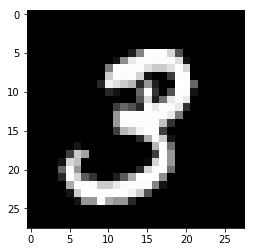

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# the data we are interested in
imgData = mnist.train.images
labelData = mnist.train.labels
    
# the date ID    
dataID = 1
# reshape the image to 2D (28x28)
img2D = np.reshape(imgData[dataID, :], (28,28))
# plot the image
plt.imshow(img2D, cmap="gray")
plt.show()

In [4]:
# the corresponding label vector
print(labelData[dataID, :])

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


# 2. Classification using neural network

We would consider a simple neural network with one hidden layer. Using the provided information, we know that the input size for the hidden layer would be 784 and the output size for the hidden layer would be 10.

Recall the *add_layer* function:

In [5]:
def add_layer(x, in_size, out_size, activation_function=None):
    W = tf.Variable(tf.random_normal([in_size, out_size]))
    # it is recommended not initialize not to zero
    b = tf.Variable(tf.zeros([1, out_size]) + 0.1) 
    Wx_b = tf.matmul(x, W) + b
    
    if activation_function is None:
        output = Wx_b
    else:
        output = activation_function(Wx_b)
        
    return output

And then we could build the neural network.

In [6]:
x_input = tf.placeholder(tf.float32, [None, 784])
y_input = tf.placeholder(tf.float32, [None, 10])
# output layer
y_hat = add_layer(x_input, 784, 10, activation_function=tf.nn.softmax)

Here we use [softmax](https://en.wikipedia.org/wiki/Softmax_function) as the activation funciton. The softmax function is a common choice for doing classification for it has some nice properties (like it is differentiable).

In [7]:
# loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_input * tf.log(y_hat),
                                              reduction_indices=[1])) 

Different from the regression, here we use the so-call [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) as our loss function. The cross-entropy is defined as 

$$
\begin{equation}
\text{Cross-entropy} = -\sum_{n} y_n\log(\hat{y}_n),
\end{equation}
$$

where $y_n$ is the true distribution for data $n$ and $\hat{y}_n$ is the predicted distribution. Note that we could treat $y_n$ as following a multinomial distribution. The cross-entropy is a measure of how close the true distribution and the predicted distribution is.

And then we would use gradient descent to minimize the loss.

In [8]:
obj = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Before we jump to the training step, we would like to add addition layers to our network for computing the prediction accuracy.

In [9]:
correct_pred = tf.equal(tf.argmax(y_input,1), tf.argmax(y_hat,1))

The variable **y_hat** we obtained from the output layber would be a vector with length 10. Values in each entry represent the likelihood (or probability after normalization) of being classified to different classes. Thus, we could choose the class with the highest likelihood as our prediction. The could be done using the function **tf.argmax**.  Same deal for the true label vector since there is only one 1 in the vector and other entries are zero. Finally, we compare the prediction to the true class using **tf.equal**. If we predict the image correctly, **correct_pred** would be True, otherwise it would be False.

In [10]:
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

To compute accuracy, we have to cast the boolean to floating points. This would convert True to 1 and False to 0. The average of a series of 0, 1 would give us the proportion of 1, which is the accuracy as well.

Finally, we initilize and start training

In [11]:
sess = tf.Session()

# initialization
init = tf.global_variables_initializer()
sess.run(init)

for i in range(1000):
    batch_img, batch_label = mnist.train.next_batch(100)
    sess.run(obj, feed_dict={x_input: batch_img, y_input: batch_label})
    if i% 50 == 0:
        print(sess.run(accuracy, 
                       feed_dict={x_input: mnist.test.images, 
                                  y_input: mnist.test.labels}))

0.0921
0.6364
0.7317
0.7764
0.7957
0.8173
0.8268
0.8337
0.8407
0.8415
0.8524
0.8567
0.8615
0.8634
0.8619
0.8663
0.8699
0.8706
0.8731
0.871


In [12]:
print(sess.run(accuracy, 
                       feed_dict={x_input: mnist.test.images, 
                                  y_input: mnist.test.labels}))

0.8734


Note that in the tutorial it is stated that this is numerically unstable. Instead, the function [tf.nn.softmax_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits) is recommended. This function should be applied on the unnormalized logits. That is, this function would serve as the activation function and the loss function combined together. To apply this function, we cannot use **add_layer**  or we cannot get the prediction. Let's re-construct our network.

In [13]:
x_input = tf.placeholder(tf.float32, [None, 784])
y_input = tf.placeholder(tf.float32, [None, 10])

# hidden layer
in_size = 784
out_size = 10
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([1, out_size])+0.1) 
Wx_b = tf.matmul(x_input, W) + b

The variable **Wx_b** is the unnormalized logits. Thus, the cross_entropy now becomes:

In [14]:
cross_entropy = \
    tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_input,
                                                logits=Wx_b))


To get **y_hat**, simply apply tf.nn.softmax on **Wx_b**.

In [15]:
y_hat = tf.nn.softmax(Wx_b)

The rest of the codes are the same.

In [16]:
obj = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
correct_pred = tf.equal(tf.argmax(y_input,1), tf.argmax(y_hat,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

sess = tf.Session()

# initialization
init = tf.global_variables_initializer()
sess.run(init)

for i in range(1000):
    batch_img, batch_label = mnist.train.next_batch(100)
    sess.run(obj, feed_dict={x_input: batch_img, y_input: batch_label})
    if i% 50 == 0:
        print(sess.run(accuracy, 
                       feed_dict={x_input: mnist.test.images, 
                                  y_input: mnist.test.labels}))

0.4333
0.8697
0.8944
0.8983
0.9064
0.9035
0.9113
0.9114
0.9107
0.914
0.911
0.9137
0.9161
0.9173
0.9155
0.9179
0.9129
0.9181
0.9178
0.9187


The accuracy rate is about 91.7%. If you compare to the previous result, you'll see they are quite different. As I checked the tutorial, it is stated that the prediction accuracy should be around 92% (from the tensorflow tutorial), which agrees with the second result. After comparing codes for a while, I realize that the first code does not get to the best solution. If we change the step number to a larger number, say, 10000, we could obtain the accuracy rate about 92% as well. The main difference between the first and the second version is how we initialize the weight matrix **W**. We use Gaussian random number to initialize in the first version and set to a zeroe matrix in the second version. It seems that setting to zeroes would be a better initialization practice, at least in this dataset.  

# 3. Classification using CNN

The 92% prediction accuracy seems good, but not good enough. [This website] (http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html) shows some recent literature of the prediction performance. It seems like it is possible to reach the accuracy rate of 99% or higher. 

Now we would implement a Convolution Neural Network (CNN) using tensorflow. CNN is a popular approach to handle image inputs. For more details about CNN, see [this vedio from standord lecture](https://www.youtube.com/watch?v=AQirPKrAyDg) and [this webpage](http://cs231n.github.io/convolutional-networks/).

Consider a simple CNN:
![cnnGraph](figs/02_cnnGraph.png)

Here are several important components:

1. Convolution (**conv_1** and **conv_2**): This adopts a [2D convolution](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) between weighted matrix **W** and then we add a bias **b** to the output. For this component we need to decide the patch size (5x5 in both components) and the output size (32 for **conv_1** and 64 for **conv_2**). 
2. Rectified linear unit (**ReLU_1** and **ReLU_2**): This is an activation function.  
3. Max pooling (pool_1 and pool_2): Here we adopt a [2x2 max pooling](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool).
4. Fully-connected layer (**fc_1** and **fc_2**): This part is similar to the neural network we have seen before. We first reduce the length to 1024 at **fc_1** and then further reduce the length to 10 (the length of the label vector) at **fc_2**.
5. Dropout: This design intent to [prevent overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). But at pointed out in the tutorial, since we are using a small convolution network the performance would be identical with and without dropout.
6. Softmax: Similar to the previous example, we compute the softmax to obtain the likelihood of the input image being classified to each class.

Let's start from scratch. Clear all the things first.

In [17]:
# Note: this would clear all the variables and functions
# use %reset -f  to avoid asking
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [18]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

#load data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [19]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

This is the function for createing parametering in the convolution component. Note that it is suggested to initialize the parameters with small noise (or small offset) instead of 0. 

In [20]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

For performing convolution, we choose strides to be 1 and use zeo padding to force the output to be the same size as input. A commonly used 2x2 max pooling is adopted here. Check [here](http://cs231n.github.io/convolutional-networks/) for more details about strides and polling.

Now we are ready to build our CNN.

In [21]:
# input variables
x_input = tf.placeholder(tf.float32, [None, 784])
y_input = tf.placeholder(tf.float32, [None, 10])
x_img_input = tf.reshape(x_input, [-1, 28, 28, 1])

# dropout setting
keep_prob = tf.placeholder(tf.float32)

We create placeholder for the inputs. Note that the original data is flattened to 1x784 and thus we have to reshape them back to 28x28. The variable **keep_prob** is the keep probability setting for the dropout operation.

In [22]:
# parameters for conv_1
W_conv_1 = weight_variable([5, 5, 1, 32])
b_conv_1 = bias_variable([32])

conv_1 = conv2d(x_img_input, W_conv_1) + b_conv_1
ReLU_1 = tf.nn.relu(conv_1)
pool_1 = max_pool_2x2(ReLU_1)

# parameters for conv_2
W_conv_2 = weight_variable([5, 5, 32, 64])
b_conv_2 = bias_variable([64])

conv_2 = conv2d(pool_1, W_conv_2) + b_conv_2
ReLU_2 = tf.nn.relu(conv_2)
pool_2 = max_pool_2x2(ReLU_2)

reshape = tf.reshape(pool_2, [-1, 7*7*64])

# parameters for fc_1
W_fc_1 = weight_variable([7*7*64, 1024])
b_fc_1 = bias_variable([1024])
fc_1 = tf.matmul(reshape, W_fc_1) + b_fc_1
ReLU_3 = tf.nn.relu(fc_1)
dropout = tf.nn.dropout(ReLU_3, keep_prob)

# parameters for fc_2
W_fc_2 = weight_variable([1024, 10])
b_fc_2 = bias_variable([10])
# output of fc_2
y_logits = tf.matmul(dropout, W_fc_2) + b_fc_2

In [23]:
# loss
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_input, 
                                            logits=y_logits))
# minimizaer to minimize cross_entropy
obj = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# calculate prediction accuracy
correct_prediction = tf.equal(tf.argmax(y_logits, 1), 
                              tf.argmax(y_input, 1)  )
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Note that here we use **tf.nn.softmax_cross_entropy_with_logits** and thus we ouput **y_logits** instead of applying softmax on it. Here we choose a different optimizer. See [here](https://www.tensorflow.org/api_guides/python/train#Optimizers) for more details.

Now we can train the model.

In [24]:
# start session and run

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        batch_img, batch_label = mnist.train.next_batch(100)
        sess.run(obj, feed_dict={x_input: batch_img, 
                                 y_input: batch_label, 
                                 keep_prob: 0.5} )
        if i % 50 == 0:
            print(sess.run(accuracy, 
                           feed_dict={x_input: mnist.test.images, 
                                      y_input: mnist.test.labels,
                                      keep_prob: 0.5}))

0.086
0.5933
0.7617
0.8336
0.8651
0.8824
0.897
0.9103
0.9201
0.9226
0.9302
0.932
0.9386
0.9373
0.9428
0.9448
0.9455
0.9465
0.9507
0.9525


It takes my laptop about 10 minutes to finish 1000 training steps. It is claimed in the tutorial that the accuracy could reach 99%. You could try to increase the step numbers to see if you can get to this high accuracy rate.